In [1]:
import os
import sys
import logging
import pickle
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import SGDRegressor, Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


from warnings import filterwarnings
filterwarnings('ignore')

from minio import Minio

# settings
MINIO_HOST = os.environ.get('MINIO_HOST', 'vesselai.epu.ntua.gr:9000')
MINIO_ACCESS_KEY = os.environ.get('MINIO_ACCESS_KEY', 'minio')
MINIO_SECRET_KEY = os.environ.get('MINIO_SECRET_KEY', 'minio123')

os.environ['MLFLOW_TRACKING_URI'] = "http://vesselai.epu.ntua.gr:5000"
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://vesselai.epu.ntua.gr:9000"
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minio123'

In [2]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
log = logging.getLogger(__name__)

In [4]:
class DataLoader(object):
    def __init__(self):
        self.random_state = 42
        self.bucket = 'uploads'
        self.directory = 'data'
        
        self.date_col = ['measurement_time']
        
        self.numerical_columns = [
             'cyl_chargeair_press', 'AE_FO_inlet_flow',
             'draught_aft_side', 'AE_FO_inlet_Temp',
             'engine_speed','DG_1_power',
             'DG_2_power','DG_4_power',
             'CAC_CW_HT_pressure', 'CAC_in_Low_Temperature_CW_temp',
             'propeller_shaft_output', 'propeller_shaft_rpm',
             'propeller_shaft_thrust', 'cyl_chargeair_temp',
             'cyl_exh_gas_temp_mean','torque',
             'AE_FO_outlet_flow', 'AE_FO_outlet_Temp',
             'Eng_in_HTCW_press', 'Eng_in_Jacket_HTCW_temp',
             'Eng_out_Jacket_HTCW_temp', 'Eng_Relative_load',
             'FO_Rack_position', 'FO_inlet_press',
             'fueloil_inlet_temperature', 'ME_FO_inlet_flow',
             'ME_FO_outlet_Temp', 'ME_FO_outlet_flow',
             'LO_Filter_P', 'LO_filter_in_press',
             'LO_in_press', 'LO_in_temp',
             'LO_out_temp_TC', 'LO_cooler_CW_out_temp'
        ]
        self.categorical_columns = [
            'DG_1_condition','DG_2_condition',
            'DG_3_condition','DG_4_condition',
            'ship_inclination'
        ]
        self.monitoring_col_name = 'ME_FO_consumption'
        self.monitoring_col = [self.monitoring_col_name]
        
        self.columns_used = self.date_col + self.numerical_columns + self.categorical_columns + self.monitoring_col
        self.for_normalization_cols = self.numerical_columns
        
        
    
    def load_dataset_(self, ship_id):
        client = Minio(
            MINIO_HOST,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=False
        )
        data_path = f'{self.directory}/{ship_id}.csv'
        obj = client.get_object(self.bucket, data_path)
        df = pd.read_csv(obj, parse_dates=self.date_col, usecols=self.columns_used)
        return df
    
    def _data_preparation(self,
                          df,
                          resampling='10min'
                         ):
        df = df.dropna()
        df = df.loc[:, (df != df.iloc[0]).any()]
        df = df.set_index('measurement_time')
        resampled_df = df.resample(resampling).sum()
        return resampled_df

In [5]:
class DataModelling(object):
    def __init__(self, lag=10, data_size=4000):
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        self.data_size = data_size
        self.lag = lag
    
    def _store_scalers(self,
                       scaler_x_path='regressor_vessel3_x_scaler.pkl',
                       scaler_y_path='regressor_vessel3_y_scaler.pkl'
                      ):
        pickle.dump(self.x_scaler, open(scaler_x_path, 'wb'))
        pickle.dump(self.y_scaler, open(scaler_y_path, 'wb'))
        
    def _data_processing(self,
                         resampled_data,
                         num_of_features,
                         sample_size
                        ):
        test_data_size = sample_size - self.data_size
        
        train_data = resampled_data.iloc[:self.data_size, :]
        test_data = resampled_data.iloc[self.data_size:, :]
        
        train_data_scaled = self.x_scaler.fit_transform(train_data)
        train_data_scaled_y = self.y_scaler.fit_transform(train_data[['ME_FO_consumption']])
        
        test_data_scaled = self.x_scaler.transform(test_data)
        test_data_scaled_y = self.y_scaler.transform(test_data[['ME_FO_consumption']])
        
        self._store_scalers()
        
        return train_data_scaled, train_data_scaled_y, test_data_scaled, test_data_scaled_y
    
    def _set_sliding_window(
        self,
        data_x,
        data_y,
        size
    ):
        X_list = []
        Y_list = []
        for i in range(self.lag, size):
            sequence = data_x[i-self.lag:i]
            target = data_y[i,0]
            X_list.append(sequence)
            Y_list.append(target)
            X_arr = np.array(X_list)
            Y_arr = np.array(Y_list)
        return X_arr, Y_arr

In [6]:
class RegressorTraining(object):
    def __init__(self, models_dict):
        self.models_dict = models_dict
        
    def _gen_metrics(self, true_value, predicted, model_name):
        
        mae = mean_absolute_error(true_value, predicted)
        mse = mean_squared_error(true_value, predicted)
        r2 = r2_score(true_value, predicted)
        
        log.info(f'{model_name} MAE: {mae}')
        log.info(f'{model_name} MSE: {mse}')
        log.info(f'{model_name} R2: {r2}')
        metrics_dict = {
            'mae': mae,
            'mse': mse,
            'r2': r2
        }
        return metrics_dict
    
    @staticmethod
    def plot_predictions(test, predicted, model_name):
        
        title=f'Predictions made by {model_name} Model'
        fig = plt.figure(figsize=(16,4))
        plt.plot(test, color='blue',label='Actual ME Fuel Consumption')
        plt.plot(predicted, alpha=0.7, color='orange',label='Predicted ME Fuel Consumption')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Normalized ME Fuel Consumption Scale')
        plt.legend()
        plt.show()
        return fig
    
    def _train(self,
               X_train,
               X_test,
               Y_train,
               Y_test,
               scaler_features_path='regressor_vessel3_x_scaler.pkl',
               scaler_y_path='regressor_vessel3_y_scaler.pkl'
              ):
        X_train_reshaped = X_train.reshape(
            X_train.shape[0],
            X_train.shape[1]*X_train.shape[2]
        )
        X_test_reshaped = X_test.reshape(
            X_test.shape[0],
            X_test.shape[1] * X_test.shape[2]
        )
        
        all_metrics = {}
        mlflow.set_experiment("ME_FO_Consumption_Vessel3_regressors")
        with mlflow.start_run():
            
            mlflow.log_artifact(scaler_features_path)
            mlflow.log_artifact(scaler_y_path)
        
            for model_item in self.models_dict.items():

                model_name = model_item[0]
                self.models_dict[model_name].fit(X_train_reshaped, Y_train)

                predicted =  self.models_dict[model_name].predict(X_test_reshaped)

                metrics_dict = self._gen_metrics(Y_test, predicted, model_name)
                fig = self.plot_predictions(Y_test, predicted, model_name)
                
                mlflow.sklearn.log_model(
                    self.models_dict[model_name],
                    model_name,
                    registered_model_name=model_name
                )
                
                figure_name = f'{model_name}_ACTUAL_VS_PREDICTED_FO_CONS_VESSEL3.png'
                mlflow.log_figure(fig, figure_name)
                for metrics_tuple in metrics_dict.items():
                    mlflow.log_metric(metrics_tuple[0], metrics_tuple[1])

                all_metrics[model_name] = metrics_dict
        return all_metrics

In [8]:
data_loader = DataLoader()
data = data_loader.load_dataset_(ship_id='ship_3')
## remove trailing zeros in `ME_FO_consumption`
data=data.iloc[:232713, :]

In [9]:
resampled = data_loader._data_preparation(data)

In [11]:
num_of_features = resampled.shape[1]
sample_size = resampled.shape[0]
train_data_size = 3500

data_modelling_obj = DataModelling(data_size=train_data_size)

train_data_scaled, train_data_scaled_y, test_data_scaled, test_data_scaled_y = data_modelling_obj._data_processing(
    resampled_data=resampled,
    num_of_features=num_of_features,
    sample_size=sample_size
)

X_train, Y_train = data_modelling_obj._set_sliding_window(size=train_data_size, data_x=train_data_scaled, data_y=train_data_scaled_y)
X_test, Y_test = data_modelling_obj._set_sliding_window(
    size=(sample_size-train_data_size),
    data_x=test_data_scaled,
    data_y=test_data_scaled_y
)

2022/12/02 15:27:29 INFO mlflow.tracking.fluent: Experiment with name 'ME_FO_Consumption_Vessel3_regressors' does not exist. Creating a new experiment.


2022-12-02 15:27:29,728 - botocore.credentials - INFO - Found credentials in environment variables.
2022-12-02 15:27:30,261 - __main__ - INFO - sgd MAE: 0.02699841035213499
2022-12-02 15:27:30,264 - __main__ - INFO - sgd MSE: 0.004162999638359961
2022-12-02 15:27:30,266 - __main__ - INFO - sgd R2: 0.9202340307317832


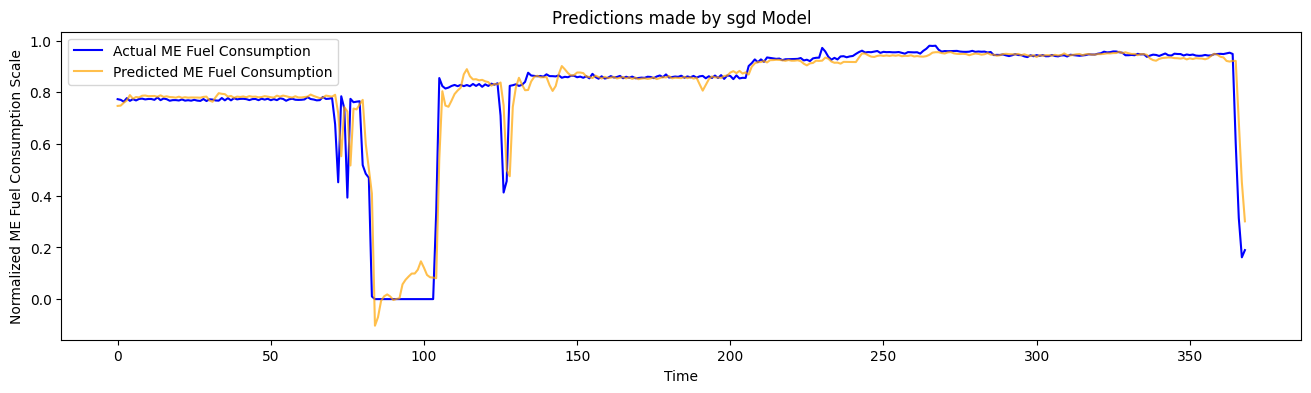

Registered model 'sgd' already exists. Creating a new version of this model...
2022/12/02 15:27:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sgd, version 7
Created version '7' of model 'sgd'.


2022-12-02 15:27:41,727 - __main__ - INFO - kernel_ridge MAE: 0.04358841554082465
2022-12-02 15:27:41,727 - __main__ - INFO - kernel_ridge MSE: 0.004378095121884584
2022-12-02 15:27:41,727 - __main__ - INFO - kernel_ridge R2: 0.9161126516256066


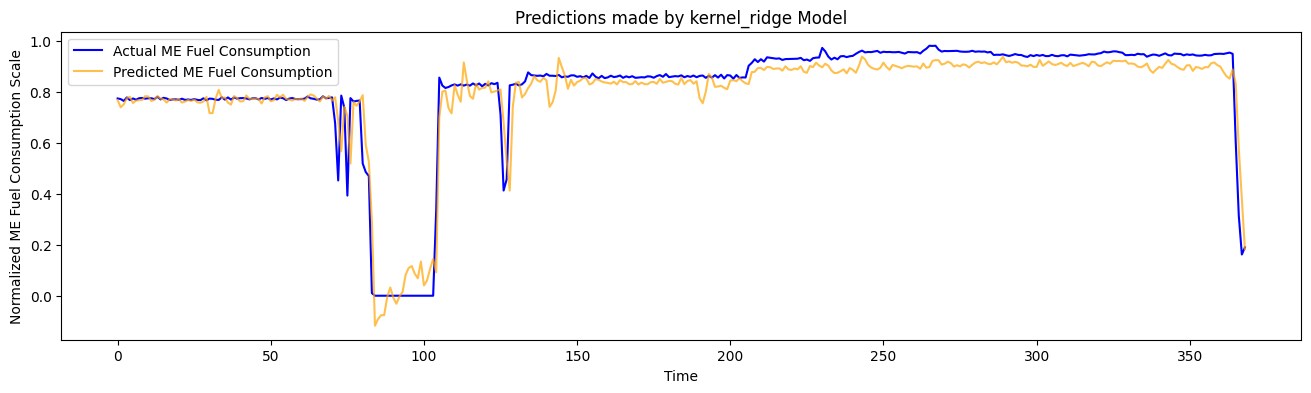

Registered model 'kernel_ridge' already exists. Creating a new version of this model...
2022/12/02 15:28:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: kernel_ridge, version 2
Created version '2' of model 'kernel_ridge'.


2022-12-02 15:28:04,143 - __main__ - INFO - bayesian_ridge MAE: 0.04179557724941294
2022-12-02 15:28:04,143 - __main__ - INFO - bayesian_ridge MSE: 0.004259563099759118
2022-12-02 15:28:04,143 - __main__ - INFO - bayesian_ridge R2: 0.9183838076322126


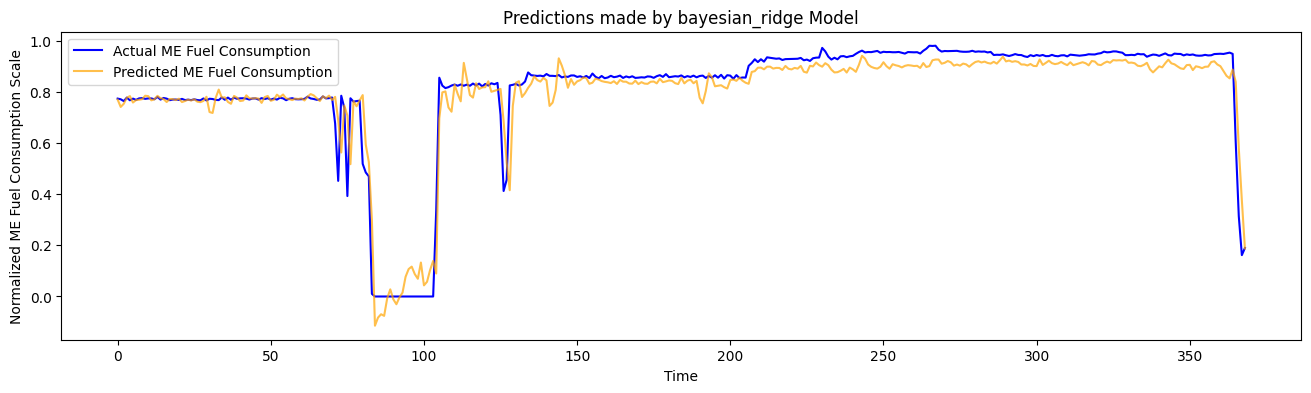

Registered model 'bayesian_ridge' already exists. Creating a new version of this model...
2022/12/02 15:28:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: bayesian_ridge, version 8
Created version '8' of model 'bayesian_ridge'.


2022-12-02 15:28:47,400 - __main__ - INFO - gradient_boosting_regressor MAE: 0.09428529417131246
2022-12-02 15:28:47,401 - __main__ - INFO - gradient_boosting_regressor MSE: 0.014940251984023595
2022-12-02 15:28:47,402 - __main__ - INFO - gradient_boosting_regressor R2: 0.7137343780585751


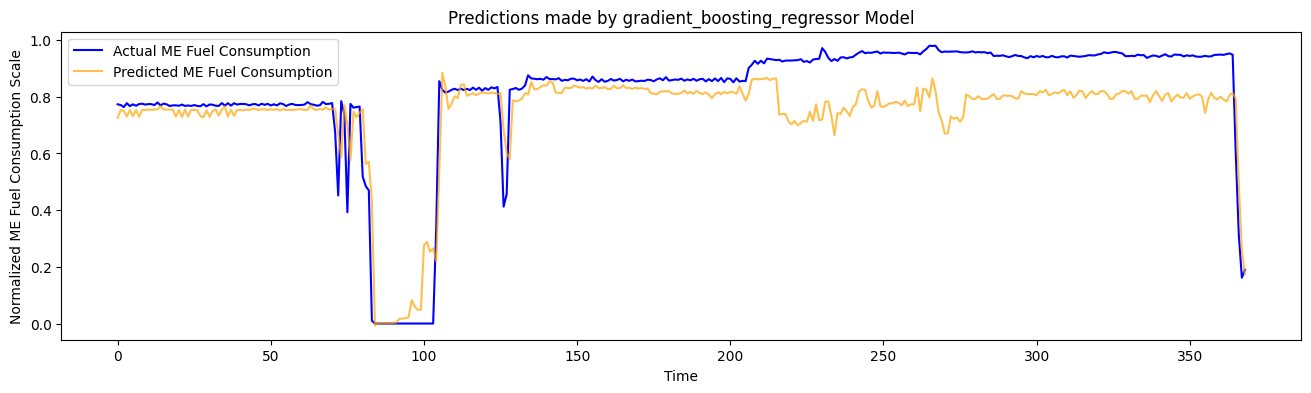

Registered model 'gradient_boosting_regressor' already exists. Creating a new version of this model...
2022/12/02 15:29:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: gradient_boosting_regressor, version 8
Created version '8' of model 'gradient_boosting_regressor'.


In [12]:
regressors_dict = {
    'sgd': SGDRegressor(max_iter=1000, tol=1e-3),
    'kernel_ridge': KernelRidge(),
    'bayesian_ridge': BayesianRidge(),
    'gradient_boosting_regressor': GradientBoostingRegressor(random_state=42)
}

regressor_obj = RegressorTraining(models_dict=regressors_dict)
metrics = regressor_obj._train(
    X_train=X_train,
    X_test=X_test,
    Y_train=Y_train,
    Y_test=Y_test
)